# Idenitfying Attractors and Dynamics on Belief Landscapes

This notebook will help you identify and label attractors for your belief landscape.  This should be an interactive process.  At a minimum, you will need a dataframe with 5 columns:  `u_id, x, y, dt (datetime)`

Set the path to the datafile in the following cell (presumed to be a feather file) and a name for the resulting output file.

See here: https://chatgpt.com/share/66e35048-6bd4-8001-86c6-48aa854e48b8



In [32]:
import pandas as pd
path_to_data = "./local_data/data_for_icwsm/icwsmtuned_random_invert_0_umap_clustered_35_trace.feather"
output_name = "./local_data/labeled_trace_climate_change_icwsm23.feather"

## First, calculate a grid to establish a vector field

In [2]:
# Read the data

trace = pd.read_feather(path_to_data)

In [3]:
df = trace[["u_id","x","y","dt"]]
grid_size = 50
df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
df['y_grid'] = ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * (grid_size - 1)).astype(int)

# Sort by user and datetime to ensure correct transition order
df.sort_values(['u_id', 'dt'], inplace=True)

# Calculate transitions
df['from_x'] = df['x_grid'].shift(1)
df['from_y'] = df['y_grid'].shift(1)
df['to_x'] = df['x_grid']
df['to_y'] = df['y_grid']

# Filter out rows that do not represent a transition (first occurrence for each user)
transitions = df[df['u_id'] == df['u_id'].shift(1)]

transitions['dx'] = transitions['to_x'] - transitions['from_x']
transitions['dy'] = transitions['to_y'] - transitions['from_y']
tx = transitions[['from_x','from_y','dx','dy']]
tx

/tmp/ipykernel_119918/2982724899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_grid'] = ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (grid_size - 1)).astype(int)
/tmp/ipykernel_119918/2982724899.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['dx'] = transitions['to_x'] - transitions['from_x']
/tmp/ipykernel_119918/2982724899.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,from_x,from_y,dx,dy
0,16.0,16.0,-1.0,-3.0
50405,15.0,13.0,3.0,5.0
50406,18.0,18.0,5.0,7.0
50408,21.0,16.0,16.0,6.0
50409,37.0,22.0,1.0,3.0
...,...,...,...,...
166283,34.0,18.0,-2.0,1.0
166284,32.0,19.0,0.0,1.0
50402,32.0,20.0,-1.0,0.0
50403,31.0,20.0,0.0,0.0


## Smoothed aggregation

The strategy here is to: 

1. use a simple Bayesian update with an uninformed prior to estimate the vector and variance of each cell and
2. use a smoothing procedure (weighted local averages) to remove spurious data

In [4]:
import numpy as np

# Utiliity functions to convert between dataframes and grids

def dataframe_to_grid(df):
    # Create mappings from from_x and from_y to indices
    unique_x = np.sort(df['from_x'].unique())
    unique_y = np.sort(df['from_y'].unique())
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize grids for mu and variance
    mu_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    mu_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dx_grid = np.full((len(unique_x), len(unique_y)), np.nan)
    var_dy_grid = np.full((len(unique_x), len(unique_y)), np.nan)

    # Fill grids with values from DataFrame
    for _, row in df.iterrows():
        i = x_to_index[row['from_x']]
        j = y_to_index[row['from_y']]
        mu_dx_grid[i, j] = row['mu_dx']
        mu_dy_grid[i, j] = row['mu_dy']
        var_dx_grid[i, j] = row['var_dx']
        var_dy_grid[i, j] = row['var_dy']
    return mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid

def grid_to_dataframe(mu_dx_grid, mu_dy_grid, x_grid=None, y_grid = None, var_dx_grid = None, var_dy_grid = None):
    data = []
    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dx_grid.shape[1]):
            
            x_coord = i if x_grid is None else x_grid[i,j]
            y_coord = j if y_grid is None else y_grid[i,j]
            row = {
                'from_x': x_coord,
                'from_y': y_coord,
                'mu_dx': mu_dx_grid[i, j],
                'mu_dy': mu_dy_grid[i, j]}
            if var_dx_grid is not None and var_dy_grid is not None:
                row['var_dx']=var_dx_grid[i, j]
                row['var_dy'] = var_dy_grid[i, j]
            data.append(row)

    return pd.DataFrame(data)

# Bayesian updating

def bayesian_update(mu_prior, var_prior, mean_sample, var_sample, count, epsilon=1e-10):
    if count == 0:
        return mu_prior, var_prior
    if count==1:
        var_sample = (var_prior + epsilon) / 2
    if var_sample==0:
        var_sample = epsilon
    precision_prior = 1 / var_prior
    precision_sample = 1 / var_sample
    combined_precision = precision_prior + count * precision_sample
    mu_posterior = (precision_prior * mu_prior + count * precision_sample * mean_sample) / combined_precision
    var_posterior = count / combined_precision
    return mu_posterior, var_posterior


def prepare_cell_data(df):
    # Group by 'from_x' and 'from_y' and calculate mean and variance
    grouped = df.groupby(['from_x', 'from_y'])
    summary = grouped.agg({
        'dx': ['mean', 'var'],
        'dy': ['mean', 'var','count'],
        
    }).reset_index()
    summary.columns = ['from_x', 'from_y', 'dx_mean', 'dx_var', 'dy_mean', 'dy_var','n']
    # Replace NaN variances (which occur if there's only one sample) with a small positive number
    summary.fillna({'dx_var': 1e-10, 'dy_var': 1e-10}, inplace=True)
    return summary

def process_df(df, mu_prior, var_prior):
    data = prepare_cell_data(df)
    results = []
    for _, row in data.iterrows():
        # Bayesian updates for dx and dy
        mu_dx, var_dx = bayesian_update(mu_prior, var_prior, row['dx_mean'], row['dx_var'], row['n'])
        mu_dy, var_dy = bayesian_update(mu_prior, var_prior, row['dy_mean'], row['dy_var'], row['n'])
        results.append([row['from_x'], row['from_y'], mu_dx, var_dx, mu_dy, var_dy])

    results_df = pd.DataFrame(results, columns=['from_x', 'from_y', 'mu_dx', 'var_dx', 'mu_dy', 'var_dy'])

    # Spatial smoothing would be applied here, using spatial_weighted_average
    return results_df

# Spatial smoothing

def spatial_weighted_average(grid, i, j, radius, mu_grid, var_grid):
    weighted_mu, weighted_var, total_weight = 0, 0, 0
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1] and (di != 0 or dj != 0):
                weight = 1 / (1 + abs(di) + abs(dj))  # Example weighting scheme
                weighted_mu += weight * mu_grid[ni, nj]
                weighted_var += weight * var_grid[ni, nj]
                total_weight += weight
    if total_weight > 0:
        return weighted_mu / total_weight, weighted_var / total_weight
    return mu_grid[i, j], var_grid[i, j]

def apply_spatial_smoothing(mu_dx_grid, mu_dy_grid, var_dx_grid, var_dy_grid, radius):
    smoothed_mu_dx_grid = np.copy(mu_dx_grid)
    smoothed_mu_dy_grid = np.copy(mu_dy_grid)
    smoothed_var_dx_grid = np.copy(var_dx_grid)
    smoothed_var_dy_grid = np.copy(var_dy_grid)

    for i in range(mu_dx_grid.shape[0]):
        for j in range(mu_dy_grid.shape[1]):
            if not np.isnan(mu_dx_grid[i, j]):
                smoothed_mu_dx_grid[i, j], smoothed_var_dx_grid[i, j] = spatial_weighted_average(
                    mu_dx_grid, i, j, radius, mu_dx_grid, var_dx_grid)
                smoothed_mu_dy_grid[i, j], smoothed_var_dy_grid[i, j] = spatial_weighted_average(
                    mu_dy_grid, i, j, radius, mu_dy_grid, var_dy_grid)

    return smoothed_mu_dx_grid, smoothed_mu_dy_grid, smoothed_var_dx_grid, smoothed_var_dy_grid


# Plotting for inspection
import matplotlib.pyplot as plt

def plot_vector_field(df, scale=1):
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        angles='xy', scale_units='xy', scale=1,
        pivot='mid'
    )
    
    
    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field')
    plt.grid(True)
    plt.show()


def plot_vector_field_with_var(df, scale=1):
    # Calculate the average variance for coloring
    df['avg_var'] = (df['var_dx'] + df['var_dy']) / 2
    
    # Plotting the vector field
    fig, ax = plt.subplots(figsize=(10, 8))
    Q = ax.quiver(
        df['from_x'], df['from_y'], 
        df['mu_dx']*scale, df['mu_dy']*scale,  # Scale the vectors
        df['avg_var'],  # Use average variance for coloring
        angles='xy', scale_units='xy', scale=1,
        cmap='viridis', pivot='mid'
    )
    
    # Adding a color bar to show the variance
    cbar = fig.colorbar(Q, ax=ax)
    cbar.set_label('Average Variance of Vector Components')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Vector Field with Variance Indication')
    plt.grid(True)
    plt.show()

The following calls depend on a couple of parameters.

- `process_df` - takes the transitions data (`tx`) and then your prior estimate of mean and variance for each vector.  Note that the code doesn't support more sophisticated priors right now, but starting with mu=0 and var=1 is a sensible choice anyway.
- `apply_spatial_smoothing` - the last parameter (radius) indicates how large a neighborhood you want to consider when smoothing the data.  1 is a good choice. Larger numbers will result in a more uniform vector field.
- `plot_vector_field_with_var` - the scale parameter (the last one) just sets a factor for plotting vector arrows.  This is purely for visualization and does not affect the data.

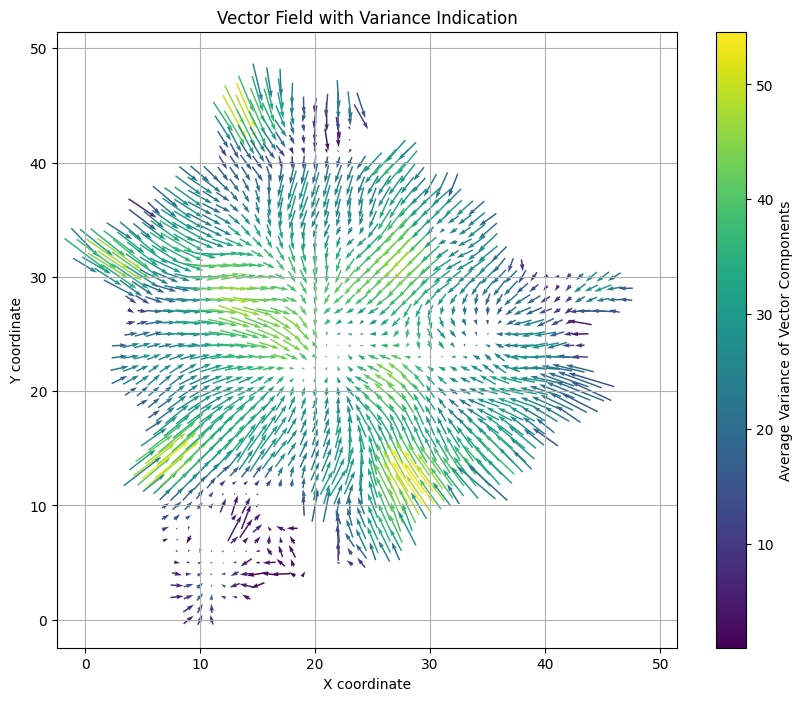

In [5]:
# Using a mean = 0 and var = 1
# Note that we are converting between table and grid-based representations to facilitate smoothing

smoothed = process_df(tx, 0,1)
mu_dx,mu_dy,var_dx,var_dy = dataframe_to_grid(smoothed)
mu_dx,mu_dy,var_dx,var_dy = apply_spatial_smoothing(mu_dx,mu_dy,var_dx,var_dy,1)
averaged = grid_to_dataframe(mu_dx,mu_dy,var_dx_grid=var_dx,var_dy_grid=var_dy)
plot_vector_field_with_var(averaged,.7)

## Extracting attractors

Now that we've prepared things, all we really need to do is run simulations to see where each trajectory winds up; after that we will just cluster endpoints.  There are a couple of details here - first, interpolating will give us some additional granularity, allowing us to resolve smaller attractors.  Also, we're using DBScan to identify attractors - this might not always work right, especially if we have adjacent attractors lying on either side of a separatrix. This is something we'll take care of another time.

In [7]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.ndimage import generic_filter
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

class DiscreteVectorFieldAnalyzer:
    def __init__(self, df, interpolation_factor=1):
        self.df = df
        self.interpolation_factor = interpolation_factor
        self._prepare_data()

    def _prepare_data(self):
        # Extract original data
        x = self.df['from_x'].values
        y = self.df['from_y'].values
        u = self.df['mu_dx'].values
        v = self.df['mu_dy'].values
        
        # Create fine grid
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        self.x_fine = np.linspace(x_min, x_max, int((x_max - x_min) * self.interpolation_factor))
        self.y_fine = np.linspace(y_min, y_max, int((y_max - y_min) * self.interpolation_factor))
        self.X_fine, self.Y_fine = np.meshgrid(self.x_fine, self.y_fine)
        
        # Prepare points for interpolation
        points = np.column_stack((x, y))
        
        # Create Delaunay triangulation for the original points
        tri = Delaunay(points)
        
        # Interpolate U and V using LinearNDInterpolator
        self.U_interp = LinearNDInterpolator(points, u, fill_value=np.nan)
        self.V_interp = LinearNDInterpolator(points, v, fill_value=np.nan)
        
        # Apply interpolation
        self.U_fine = self.U_interp(self.X_fine, self.Y_fine)
        self.V_fine = self.V_interp(self.X_fine, self.Y_fine)
        
        # Create mask for valid data points
        # fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        # self.valid_mask = tri.find_simplex(fine_points) >= 0
        # self.valid_mask = self.valid_mask.reshape(self.X_fine.shape)

        # Create a more restrictive mask for valid data points
        fine_points = np.column_stack((self.X_fine.ravel(), self.Y_fine.ravel()))
        in_simplex = tri.find_simplex(fine_points) >= 0
        has_valid_values = ~np.isnan(self.U_fine.ravel()) & ~np.isnan(self.V_fine.ravel())
        self.valid_mask = (in_simplex & has_valid_values).reshape(self.X_fine.shape)
        
        # Apply mask to U_fine and V_fine
        self.U_fine[~self.valid_mask] = np.nan
        self.V_fine[~self.valid_mask] = np.nan
        
        self.grid_shape = self.X_fine.shape


    def generate_trajectory(self, start_index, max_steps=1000, step_size=0.1):
        trajectory = [start_index]
        current_point = np.array([self.X_fine[start_index[0], start_index[1]], 
                                  self.Y_fine[start_index[0], start_index[1]]])
        visited = set([start_index])
        
        for _ in range(max_steps):
            i, j = self.discretize_point(current_point)
            if not self.valid_mask[i, j]:
                print("We are out of bounds")
                
            delta = self.vector_field(i, j)
            
            if np.all(np.abs(delta) < 1e-6):
                break  # Stopping point detected
            
            # Euler integration step
            next_point = current_point + delta * step_size
            
            # Discretize the new point to get the next grid index
            next_index = self.discretize_point(next_point)
            
            if not (0 <= next_index[0] < self.grid_shape[0] and 0 <= next_index[1] < self.grid_shape[1]):
                break  # Out of bounds

            if not self.valid_mask[next_index[0], next_index[1]]:
                break 
            
            if next_index in visited:
                break  # Cycle detected
            
            visited.add(next_index)
            trajectory.append(next_index)
            current_point = next_point
        
        return trajectory


    def process_point(self, args):
        index, step_size = args
        trajectory = self.generate_trajectory(index, step_size=step_size)
        return trajectory

    def analyze_vector_field(self, step_size=0.1):
        valid_indices = list(zip(*np.where(self.valid_mask)))
        
        # Create a list of tuples containing both the index and step_size
        args = [(index, step_size) for index in valid_indices]
        
        with mp.Pool() as pool:
            trajectories = pool.map(self.process_point, args)


        
        
        return trajectories


    def discretize_point(self, point):
        """Convert a continuous point to the nearest grid index."""
        j = np.clip(np.searchsorted(self.x_fine, point[0]), 0, self.grid_shape[1] - 1)
        i = np.clip(np.searchsorted(self.y_fine, point[1]), 0, self.grid_shape[0] - 1)
        return (int(i), int(j))
        
   

    def vector_field(self, i, j):
        """Return the vector field at the given grid indices."""
        return np.array([self.U_fine[i, j], self.V_fine[i, j]])

 
    def find_attractors_and_basins(self, trajectories, min_quality=10, threshold=0.1, samples=5):
        valid_indices = list(zip(*np.where(self.valid_mask)))
        # Convert indices to coordinates for clustering
        end_indices = [t[-1] for t in trajectories]
        end_points = np.array([(self.X_fine[i, j], self.Y_fine[i, j]) for i, j in end_indices])
        
        clustering = DBSCAN(eps=threshold, min_samples=samples).fit(end_points)
        
        unique_labels = np.unique(clustering.labels_)
        print(f"Unique labels: {unique_labels}")
        attractors = []
        valid_labels = {}  # Dictionary to map DBSCAN labels to new attractor indices
        new_label = 0  # Counter for new labels
        
        for label in unique_labels:
            if label != -1:  # -1 is noise in DBSCAN
                cluster_points = end_points[clustering.labels_ == label]
                quality = 0
                cluster_indices = np.where(clustering.labels_ == label)[0]
                for idx in cluster_indices:
                    quality += len(trajectories[idx])
                if quality > min_quality:
                    attractors.append(np.mean(cluster_points, axis=0))
                    valid_labels[label] = new_label
                    new_label += 1
        
        attractors = np.array(attractors)
        print(f"Number of attractors after pruning: {len(attractors)}")
        
        # Assign basins
        basins = np.full(self.grid_shape, -1, dtype=int)
        for (i, j), label in zip(valid_indices, clustering.labels_):
            basins[i, j] = valid_labels.get(label, -1)
        
        # Fill pruned basins with nearest valid basin
        valid_points = []
        valid_labels_list = []
        for i, j in valid_indices:
            if basins[i, j] != -1:
                valid_points.append((self.X_fine[i, j], self.Y_fine[i, j]))
                valid_labels_list.append(basins[i, j])
        
        if not valid_points:
            print("Warning: All attractors were pruned.")
            return attractors, basins  # Return if no valid points (all attractors pruned)
        
        tree = cKDTree(valid_points)
        
        pruned_points = []
        pruned_indices = []
        for i, j in valid_indices:
            if basins[i, j] == -1:
                pruned_points.append((self.X_fine[i, j], self.Y_fine[i, j]))
                pruned_indices.append((i, j))
        
        if pruned_points:
            distances, indices = tree.query(pruned_points, k=1)
            for (i, j), idx in zip(pruned_indices, indices):
                basins[i, j] = valid_labels_list[idx]
        
        return attractors, basins

    def plot_results(self, attractors, basins):
        plt.figure(figsize=(12, 10))
        masked_basins = np.ma.masked_where(~self.valid_mask, basins)
        plt.imshow(masked_basins, extent=[self.x_fine.min(), self.x_fine.max(), 
                                          self.y_fine.min(), self.y_fine.max()],
                   origin='lower', alpha=0.6, cmap='viridis')
        plt.streamplot(self.X_fine, self.Y_fine, self.U_fine, self.V_fine, 
                       density=3, color='gray', arrowsize=0.5)
        plt.scatter(attractors[:, 0], attractors[:, 1], c='red', s=100, label='Attractors')
        plt.colorbar(label='Basin of Attraction')
        plt.title('Vector Field with Basins of Attraction')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.show()

Again, some parameter explanations here:

- `DiscreteVectorFieldAnalyzer` - the `interpolation_factor` increases the granularity of the vector field.  This helps to resolve smaller attractors - it is a form of bootstrapping, in that we are creating data based on what we already have.  I have found a factor of four to be useful, but YMMV.
- `DiscreteVectorFieldAnalyzer.analyze_vector_field` - we are running walks over the vector field using Euler's method.  However, because we are on a discrete grid, step sizes that are too small will generate a single attractor for every grid point.  Too large, and we might only find the most dominant attractors. So, this value ultimately has a large impact on how many attractors you find. You'll want to fiddle with it until it seems like you are getting attractors that roughly correspond to what you see in the vector map.  Note that the next step will allow you to screen out smaller, spurious attractors.  These sometimes appear at the edge of the map where data can be a little soft.
- `DiscreteVectorFieldAnalyzer.find_attractors_and_basins` - the `min_quality` parameter is a simple heuristic for pruning smaller, spurious attractors. Quality is just the sum of all trajectory lengths leading to an attractor.  So, if you've got some really small attractors with just a few short paths, the `min_quality` parameter will enable you to prune them. The `threshold` and `samples` parameters are just DBScan's `epsilon` and `min_samples` parameters.  This controls the clustering procedure used to identify attractors. 

In [8]:
analyzer = DiscreteVectorFieldAnalyzer(averaged, interpolation_factor=4)
trajectories = analyzer.analyze_vector_field(step_size=.8)

Unique labels: [-1  0  1  2  3  4  5  6]
Number of attractors after pruning: 5


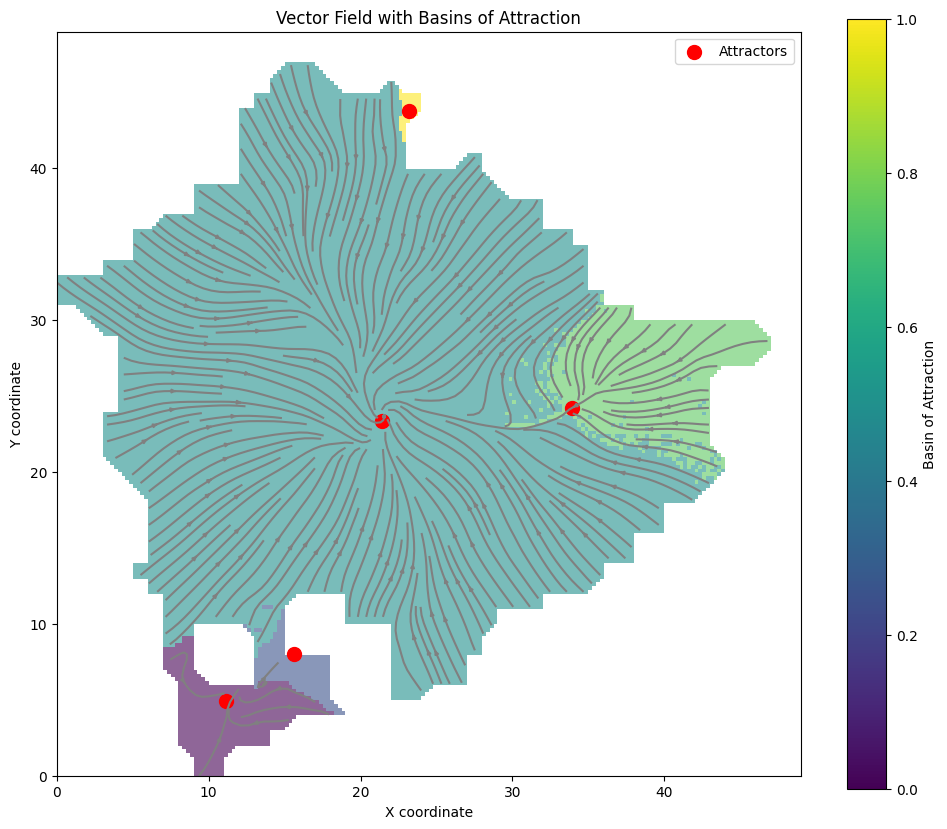

In [10]:
attractors, basins = analyzer.find_attractors_and_basins(trajectories,min_quality=40,threshold=1,samples=5)
analyzer.plot_results(attractors,basins)

## Finally, smoothing the data

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.spatial import Delaunay

class BasinSmoother:
    def __init__(self, basins):
        self.basins = basins
        #self.attractors = np.array(attractors)
        self.num_attractors = len(attractors)
        self.shape = basins.shape

    def create_basin_mask(self, attractor_index):
        return (self.basins == attractor_index).astype(np.uint8)

    def smooth_basin(self, mask, smoothing_factor=2, simplification_factor=0.01):
        # Ensure odd-sized kernel by adding 1 if smoothing_factor is even
        kernel_size = smoothing_factor + 1 if smoothing_factor % 2 == 0 else smoothing_factor
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Apply morphological closing to fill small holes and smooth edges
        closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # Find contours of the closed mask
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return mask
        
        # Simplify the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = simplification_factor * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Create a new mask from the simplified contour
        smooth_mask = np.zeros_like(mask)
        cv2.drawContours(smooth_mask, [approx], 0, 1, -1)
        
        # Ensure all original points are included (prevents orphaned points)
        smooth_mask = np.logical_or(smooth_mask, mask).astype(np.uint8)
        
        return smooth_mask

    def fill_holes(self, mask):
        # Find contours of the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # If no contours found, return the original mask
        if not contours:
            return mask
        
        # Create a new mask and fill in the contours
        filled_mask = np.zeros_like(mask)
        cv2.drawContours(filled_mask, contours, -1, 1, -1)
        
        return filled_mask

    def concave_hull_smooth(self, mask, alpha=0.1, spline_smoothness=0, max_iterations=1000):
        # Get boundary points
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return mask
        
        boundary_points = contours[0].squeeze()
        
        # Check if boundary_points is empty or has only one point
        if boundary_points.size == 0 or len(boundary_points.shape) == 1:
            return mask
        
        # Ensure boundary_points is 2D
        if len(boundary_points.shape) > 2:
            boundary_points = boundary_points.reshape(-1, 2)
        
        # Check if we have enough points for triangulation
        if len(boundary_points) < 3:
            return mask

        try:
            # Compute Delaunay triangulation
            tri = Delaunay(boundary_points)

            # Find edges that satisfy alpha criterion
            edges = set()
            for simplex in tri.simplices:
                for i in range(3):
                    j = (i + 1) % 3
                    p1, p2 = boundary_points[simplex[i]], boundary_points[simplex[j]]
                    if np.linalg.norm(p1 - p2) < 1 / alpha:
                        edges.add(tuple(sorted((tuple(p1), tuple(p2)))))

            # Create ordered edge list
            ordered_edges = list(edges)
            if not ordered_edges:
                return mask
            
            hull = [ordered_edges[0][0], ordered_edges[0][1]]
            used_edges = set([ordered_edges[0]])

            iteration = 0
            while len(used_edges) < len(edges) and iteration < max_iterations:
                last_point = hull[-1]
                found_edge = False
                for edge in edges:
                    if edge in used_edges:
                        continue
                    if last_point in edge:
                        next_point = edge[0] if edge[1] == last_point else edge[1]
                        hull.append(next_point)
                        used_edges.add(edge)
                        found_edge = True
                        break
                if not found_edge:
                    # If no edge is found, break the loop to avoid infinite iteration
                    break
                iteration += 1

            hull = np.array(hull)

            # Fit a spline to the hull points
            if len(hull) >= 4:  # Need at least 4 points for a periodic spline
                tck, u = splprep(hull.T, u=None, s=spline_smoothness, per=1)
                u_new = np.linspace(u.min(), u.max(), 1000)
                smooth_hull = np.column_stack(splev(u_new, tck))
            else:
                smooth_hull = hull

            # Create a new mask from the smooth hull
            smooth_mask = np.zeros_like(mask)
            cv2.fillPoly(smooth_mask, [smooth_hull.astype(np.int32)], 1)

            # Fill any holes in the smooth mask
            smooth_mask = self.fill_holes(smooth_mask)

            # Ensure all original points are included
            smooth_mask = np.logical_or(smooth_mask, mask).astype(np.uint8)

            return smooth_mask
        except Exception as e:
            print(f"Error in concave hull smoothing: {e}")
            return mask

    def process_basins(self, smooth=True, smoothing_factor=2, simplification_factor=0.01, alpha=0.1, spline_smoothness=0):
        # Calculate basin sizes and strengths
        basin_sizes = np.array([np.sum(self.basins == i) for i in range(self.num_attractors)])
        strengths = 1 / basin_sizes
        strengths = strengths / np.max(strengths)  # Normalize

        # Sort attractors by increasing strength (decreasing basin size)
        sorted_indices = np.argsort(strengths)

        processed_basins = np.full(self.shape, -1, dtype=int)

        for i in sorted_indices:
            mask = self.create_basin_mask(i)
            
            if smooth:
                # Apply initial smoothing
                smooth_mask = self.smooth_basin(mask, smoothing_factor, simplification_factor)
                # Apply final concave hull smoothing
                smooth_mask = self.concave_hull_smooth(smooth_mask, alpha, spline_smoothness)
            else:
                smooth_mask = mask

            # Update the processed basins
            processed_basins[smooth_mask == 1] = i

        return processed_basins

    def visualize_processed_basins(self, processed_basinss):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Plot original basins
        ax1.imshow(self.basins, cmap='viridis', interpolation='nearest', origin='lower')
        
        ax1.set_title("Original Basins")
        
        # Plot processed basins
        ax2.imshow(processed_basins, cmap='viridis', interpolation='nearest', origin='lower')
       
        title = "Smoothed Basins"
        ax2.set_title(title)
        
        plt.show()

The attractor basins developed in the previous method usually have fuzzy boundaries, and can be discontinuous.  The `BasinSmoother` is designed to fix this.  It requires tuning and visual investigation.  You are trying to get relatively smooth boundaries with no orphan points (disconnected from their basin) and no "holes" in basins.  It is probably easier to just play with things and develop a visual intuition rather than try to understand the parameters, but here's a brief explanation:

- `smoothing_factor` -  The first step in the smoother tries to fill in holes in the attractor basins by passing a kernel over the basin and filling in any empty bits.  We are using OpenCV's `morphologyEx` function with a `CLOSE` operation; see [this explanation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html). The `smoothing_factor` controls the size of the kernel.
- `simplification_factor` - After that, we try to find a polygon that approximates the contour of the shape.  Note that if we still have a disconnected basin here or holes our contours will pull those out, so the previous step is pretty important. We are using OpenCV's [`approxPolyDP` function](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c), and the `simplification_factor` controls `epsilon` in that function.  Larger values will lead to less complex, more approximate polygons.
- `alpha` - After the preceding, we then move on to a second pass of smoothing.  We may still at this point have disconnected portions a jagged boundary, so our goal is to fix these problems and generate a smoother boundary.  First we create a triangular mesh using the [`Delaunay` algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html) and then attempt to shink the mesh by deleting edges.  `alpha` controls which edges we keep, with smaller values allowing for a more concave shape (think of this like "shrink wrapping" the polygon, where `alpha` is the thickness of the shrink wrap.  Thicker shrink wraps do not resolve as much detail in the underlying object.
- `spline_smoothness` - Finally, we draw a spline around the outside for a final pass of smoothing - the `spline_smoothness` parameter controls how smooth the line is, with higher values yeilding smoother lines.

You might wonder if all of this is necessary?  Maybe not! But it is quite flexible, and enables us to get a pretty nice boundary.  Future iterations might simplify this process.

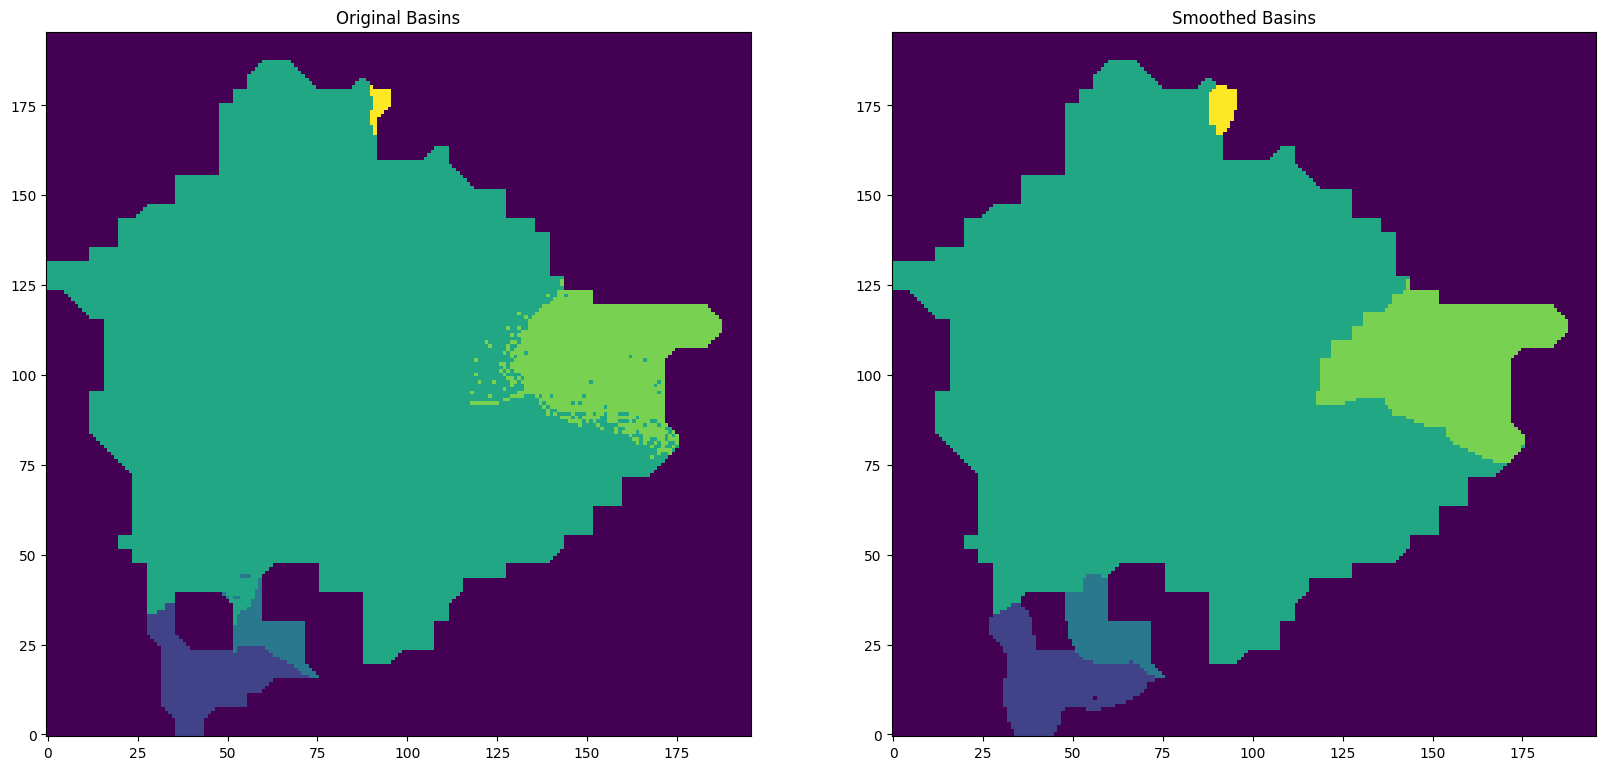

In [20]:
# Usage
smoother = BasinSmoother(basins)

# Process with smoothing
smoothed_basins = smoother.process_basins(smooth=True, smoothing_factor=7, simplification_factor=0.001, alpha=0.05, spline_smoothness=3)
smoother.visualize_processed_basins(smoothed_basins, smooth=True)

## Mapping back to trace data

The rest of this is just to map the results back to the trace data.  Note that we do a little estimation here, because the raw trace data may have points slightly beyond the original vector field.  We use a nearest neighbors search to assign these points.

In [21]:
import numpy as np
from scipy.spatial import cKDTree

def map_basins_to_trace(trace_df, smoothed_basins):
    # Get the dimensions of the smoothed basins array
    basin_height, basin_width = smoothed_basins.shape
    
    # Get the min and max of x and y from the original trace data
    x_min, x_max = trace_df['x'].min(), trace_df['x'].max()
    y_min, y_max = trace_df['y'].min(), trace_df['y'].max()
    
    def get_basin_index(x, y):
        # Normalize the x and y coordinates to [0, 1]
        x_norm = (x - x_min) / (x_max - x_min)
        y_norm = (y - y_min) / (y_max - y_min)
        
        # Map to basin indices
        basin_x = int(x_norm * (basin_width - 1))
        basin_y = int(y_norm * (basin_height - 1))
        
        # Ensure we don't go out of bounds
        basin_x = max(0, min(basin_x, basin_width - 1))
        basin_y = max(0, min(basin_y, basin_height - 1))
        
        return smoothed_basins[basin_y, basin_x]
    
    # Apply the mapping function to each row in the trace dataframe
    trace_df['basin'] = trace_df.apply(lambda row: get_basin_index(row['x'], row['y']), axis=1)
    
    # Identify unassigned points (assuming -1 is used for unassigned)
    unassigned_mask = trace_df['basin'] == -1
    
    if unassigned_mask.sum() > 0:
        # Create a KD-tree of assigned points
        assigned_points = trace_df.loc[~unassigned_mask, ['x', 'y']].values
        assigned_tree = cKDTree(assigned_points)
        
        # Find nearest assigned neighbor for each unassigned point
        unassigned_points = trace_df.loc[unassigned_mask, ['x', 'y']].values
        _, indices = assigned_tree.query(unassigned_points)
        
        # Assign the basin of the nearest neighbor
        trace_df.loc[unassigned_mask, 'basin'] = trace_df.loc[~unassigned_mask, 'basin'].iloc[indices].values
    
    return trace_df

In [22]:
mapped_trace = map_basins_to_trace(trace,basins)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_trace_data_by_basin(trace_df, output_file=None):
    # Set the seaborn style
    sns.set_style("whitegrid")
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create a color palette for the basins
    n_basins = trace_df['basin'].nunique()
    palette = sns.color_palette("husl", n_colors=n_basins)

    # Create the scatter plot
    scatter = ax.scatter(
        trace_df['x'], 
        trace_df['y'],
        c=trace_df['basin'],
        cmap=plt.cm.colors.ListedColormap(palette),
        s=1,  # Small point size
        alpha=0.1,  # Low alpha for better visibility of dense areas
    )

    # Customize the plot
    ax.set_title('Trace Data Colored by Basin', fontsize=16)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)

    # Add a color bar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Basin', fontsize=12)
    
    # Adjust the color bar ticks to show only integer values
    cbar.set_ticks(np.arange(n_basins) + 0.5)
    cbar.set_ticklabels(range(n_basins))

    # Improve the layout
    plt.tight_layout()

    # Save the plot if an output file is specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {output_file}")
    
    # Show the plot
    plt.show()


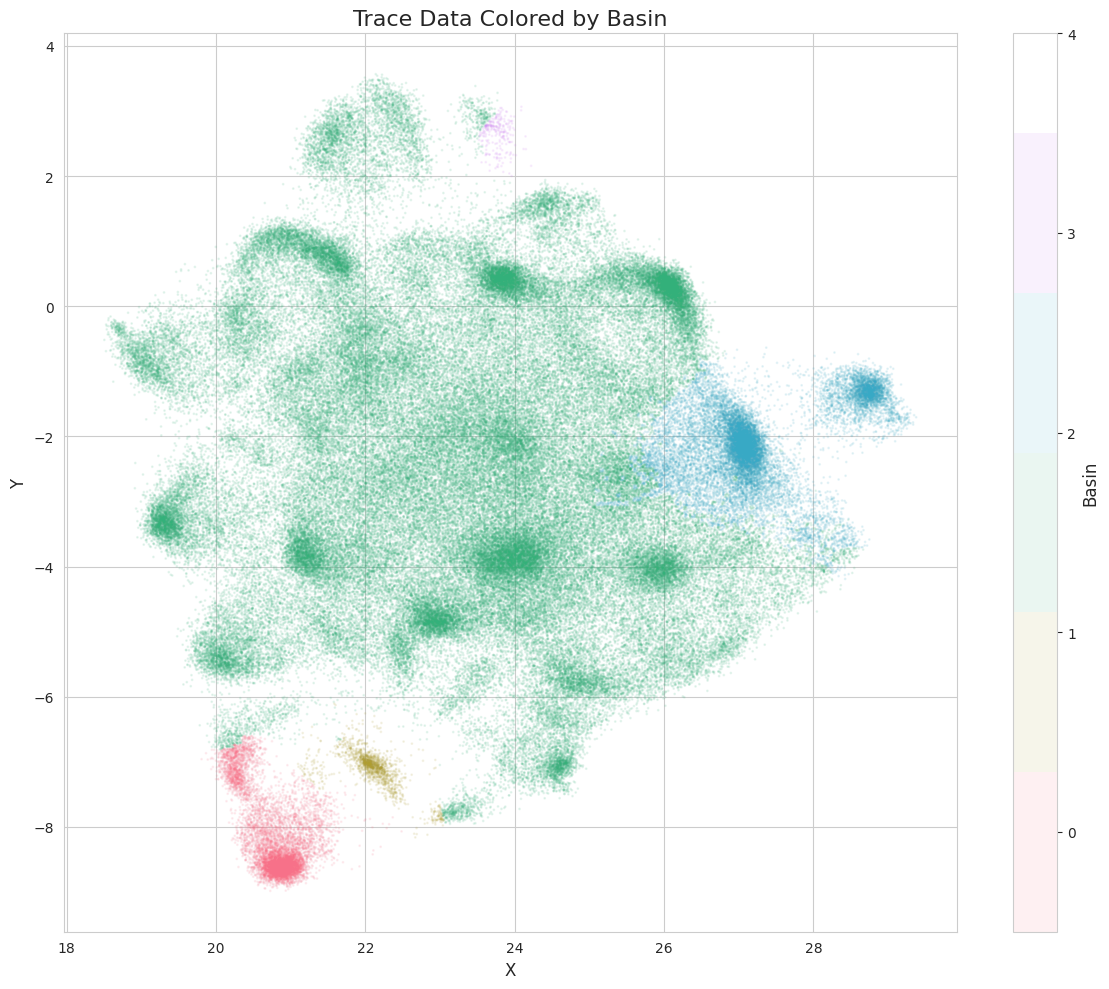

In [24]:
plot_trace_data_by_basin(mapped_trace)

## Process variance

We'll also take our original variance estimates from the attractor field and attach those to the data frame.  Once again, there's a little estimation here at the boundaries of the vector field.

In [27]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

def process_variance(trace_df, x_variance_grid, y_variance_grid):
    """  
    Attaches variance to the original trace data.  Note that this destructively modifies the data frame.
    """
    # 1. Average the variance grids
    avg_variance_grid = (x_variance_grid + y_variance_grid) / 2

    # 2. Prepare data for interpolation, excluding NaN values
    x, y = np.mgrid[0:avg_variance_grid.shape[1], 0:avg_variance_grid.shape[0]]
    valid_mask = ~np.isnan(avg_variance_grid)
    points = np.column_stack((x[valid_mask], y[valid_mask]))
    values = avg_variance_grid[valid_mask]

    # Create interpolator
    interp_func = LinearNDInterpolator(points, values, fill_value=np.nan)

    # 3. Map variance to trace data
    x_min, x_max = trace_df['x'].min(), trace_df['x'].max()
    y_min, y_max = trace_df['y'].min(), trace_df['y'].max()
    x_norm = (trace_df['x'] - x_min) / (x_max - x_min)
    y_norm = (trace_df['y'] - y_min) / (y_max - y_min)
    scaled_x = x_norm * (avg_variance_grid.shape[1] - 1)
    scaled_y = y_norm * (avg_variance_grid.shape[0] - 1)
    trace_df['variance'] = interp_func(np.column_stack((scaled_x, scaled_y)))

    # 4. Fill NaN values using nearest neighbor
    nan_mask = np.isnan(trace_df['variance'])
    valid_mask = ~nan_mask
    
    if nan_mask.sum() > 0:
        valid_points = np.column_stack((scaled_x[valid_mask], scaled_y[valid_mask]))
        valid_values = trace_df.loc[valid_mask, 'variance'].values
        
        kdtree = cKDTree(valid_points)
        nan_points = np.column_stack((scaled_x[nan_mask], scaled_y[nan_mask]))
        
        _, indices = kdtree.query(nan_points, k=1)
        trace_df.loc[nan_mask, 'variance'] = valid_values[indices]
    
    return trace_df


# Usage
# trace_df = ... # Your trace dataframe
# x_variance_grid = ... # Your x variance grid
# y_variance_grid = ... # Your y variance grid
# process_and_visualize_variance(trace_df, x_variance_grid, y_variance_grid)

In [28]:
mapped_trace = process_variance(mapped_trace, var_dx,var_dy)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_trace(trace_df):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create a normalized colormap
    norm = colors.Normalize(vmin=trace_df['variance'].min(), vmax=trace_df['variance'].max())
    
    # Create the scatter plot with low alpha
    scatter = ax.scatter(
        trace_df['x'],
        trace_df['y'],
        c=trace_df['variance'],
        cmap='viridis',
        s=1,
        alpha=0.1,
        norm=norm
    )
    
    # Create a separate mappable for the colorbar with full opacity
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    
    # Add colorbar using the separate mappable
    cbar = fig.colorbar(sm, ax=ax, label='Variance')
    
    ax.set_title('Trace Data Colored by Variance')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()


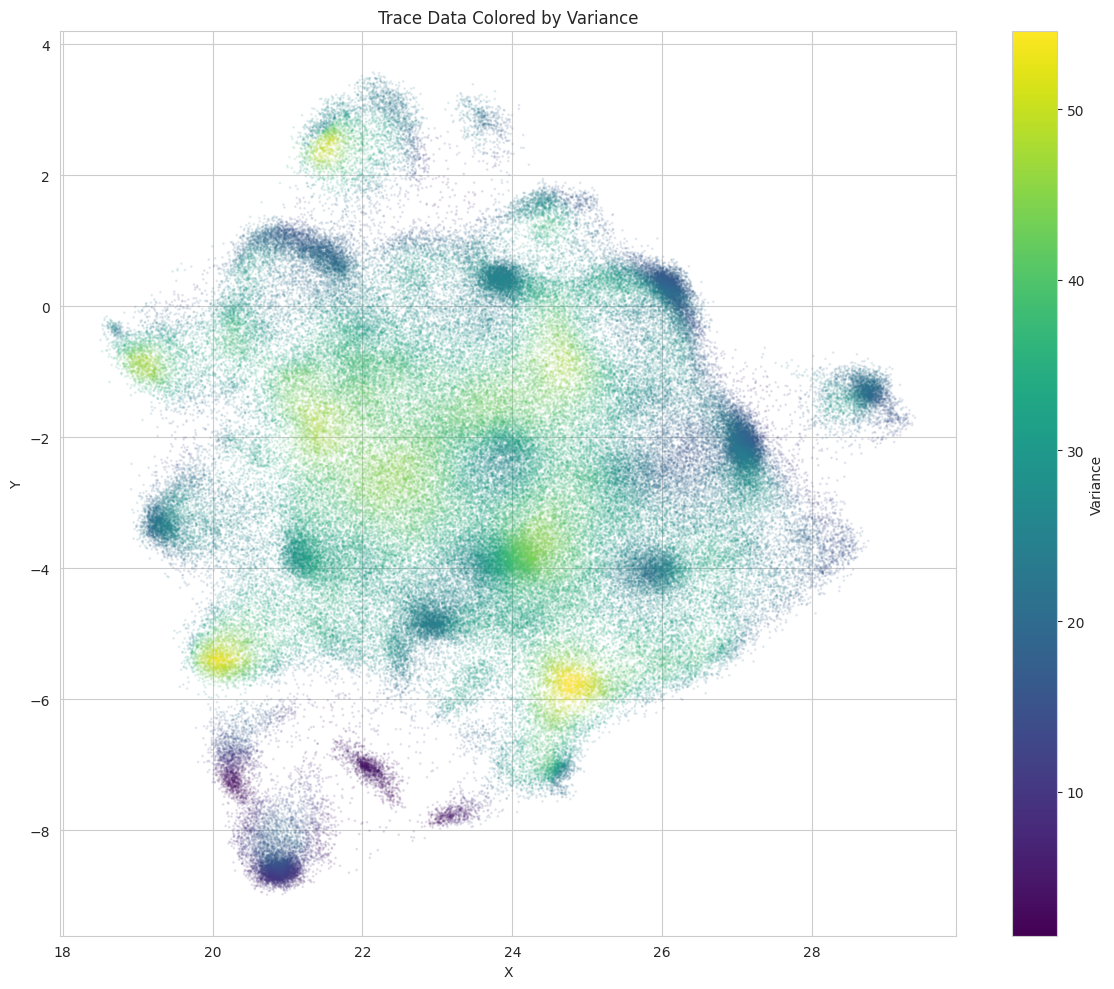

In [30]:
plot_trace(mapped_trace)

In [31]:
# All important - save the file!
mapped_trace.to_feather(output_name)